In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pypi-iarc-packages/
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp -r /kaggle/input/pypi-iarc-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pypi-iarc-packages/
Processing /kaggle/input/pypi-iarc-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from functools import partial

from tabpfn import TabPFNClassifier
from sklearn import preprocessing
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# custom modules
from preproc import load_data,scale_data

***
## loading data

In [3]:
train,test,input_cols = load_data()

display(train)
display(test)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train,test,scaler = scale_data(train, test, input_cols, impute_only=True)

display(train)
display(test)
scaler

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1.0,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0.0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1.0,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1.0,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1.0,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.00

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [5]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [6]:
def balanced_logloss_(y_pred, y_true, eps=1e-15):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2


In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
model_params = {
    'device':'cpu',
    'seed': 2112,
    'feature_shift_decoder': True,
    'multiclass_decoder': 'permutation',
    'no_preprocess_mode': False,
    'N_ensemble_configurations': 32,
}

In [9]:
VERBOSE = True

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)

        clf = TabPFNClassifier(**model_params)
        clf.fit(
            train_df[input_cols].values, 
            train_df["Class"].values, 
            overwrite_warning=True
        )
        
        y_pred = clf.predict_proba(valid_df[input_cols].values)
        valid_loss = balanced_logloss_(y_pred[:,1], valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred[:,1]
        
        models.append(clf)
        metrics.append(valid_loss)
        
    oof_dfs.append(oof)

REPEAT NUMBER: 1/10
training model for fold: 1/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 2/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 3/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 4/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 5/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
REPEAT NUMBER: 2/10
training model for fold: 1/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 2/5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
training model for fold: 3/5
Loading model that can be used for inference only
Using a Transformer 

***
## OOF analysis and calibration

In [10]:
oof_scores = oof_dfs[0].copy()
oof_scores.rename({"pred_proba":"pred_proba0"}, axis=1, inplace=True)

for i in range(1, len(oof_dfs)):
    _df = oof_dfs[i].copy()
    _df.rename({"pred_proba":f"pred_proba{i}"}, axis=1, inplace=True)
    oof_scores = oof_scores.merge(_df, on=["Id","Class"])
    
oof_scores["avg_proba"] = oof_scores.iloc[:,2:].mean(axis=1)
oof_scores

,Id,Class,pred_proba0,pred_proba1,pred_proba2,pred_proba3,pred_proba4,pred_proba5,pred_proba6,pred_proba7,pred_proba8,pred_proba9,avg_proba
0,000ff2bfdfe9,1,0.515909,0.718304,0.669633,0.564204,0.544494,0.669896,0.625985,0.730940,0.785949,0.719229,0.654454
1,007255e47698,0,0.000025,0.000037,0.000062,0.000145,0.000101,0.000021,0.000097,0.000057,0.000187,0.000111,0.000084
2,013f2bd269f5,0,0.072144,0.069725,0.107741,0.126337,0.133439,0.110381,0.116240,0.037202,0.069827,0.058020,0.090106
3,043ac50845d5,0,0.010482,0.012729,0.005603,0.024245,0.014781,0.017477,0.017064,0.007597,0.014351,0.010702,0.013503
4,044fb8a146ec,1,0.674088,0.774080,0.631234,0.518978,0.775282,0.619779,0.733816,0.669332,0.599723,0.624101,0.662041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0,0.031856,0.062124,0.051972,0.028709,0.025874,0.049928,0.040796,0.022455,0.047805,0.004627,0.036614
613,fd895603f071,0,0.066330,0.024586,0.085725,0.090433,0.129014,0.033926,0.032191,0.037395,0.066155,0.039572,0.060533
614,fd8ef6377f76,0,0.023394,0.013741,0.007401,0.005626,0.008091,0.013686,0.014968,0.007974,0.008111,0.014644,0.011764
615,fe1942975e40,0,0.076513,0.030280,0.059740,0.085058,0.066740,0.007721,0.109517,0.044633,0.038382,0.073959,0.059254


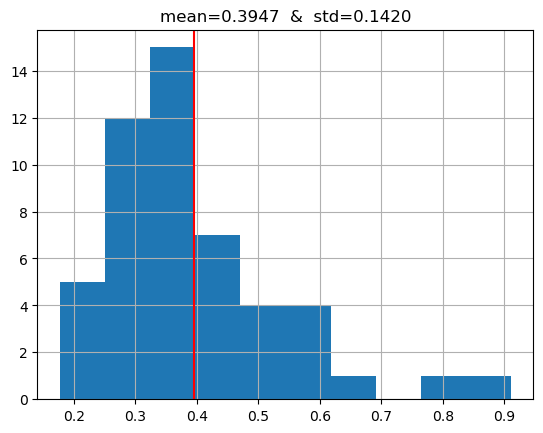

In [11]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

In [12]:
def calibrate_probs(prob_class1, scale_factor):
    p0 = (1-prob_class1).copy()
    p1 = prob_class1.copy()
    p1 *= scale_factor
    normalized_p1 = p1 / (p0+p1)
    return normalized_p1

def calculate_overall_metric(
        oof_dfs:list, 
        factor:int
    ) -> float:
    
    all_metrics = list()
    for oof in oof_dfs:
        oof = oof.copy()

        p0 = 1 - oof.pred_proba.values.copy()
        p1 = oof.pred_proba.values.copy()
        p1 *= factor
        scaled_p1 = p1 / (p0+p1)
        oof["pred_proba"] = scaled_p1

        metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
        all_metrics.append(metric)
    
    return np.mean(all_metrics[1:])

out = minimize(partial(calculate_overall_metric, oof_dfs), x0=1)
display(out)

scale_factor = out.x[0]
display(scale_factor)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.27842728510116455
        x: [ 5.688e+00]
      nit: 10
      jac: [-5.689e-06]
 hess_inv: [[ 3.980e+02]]
     nfev: 22
     njev: 11

5.688356403611531

####################################################################################################
CV repeat nbr: 1 - metric: 0.3796


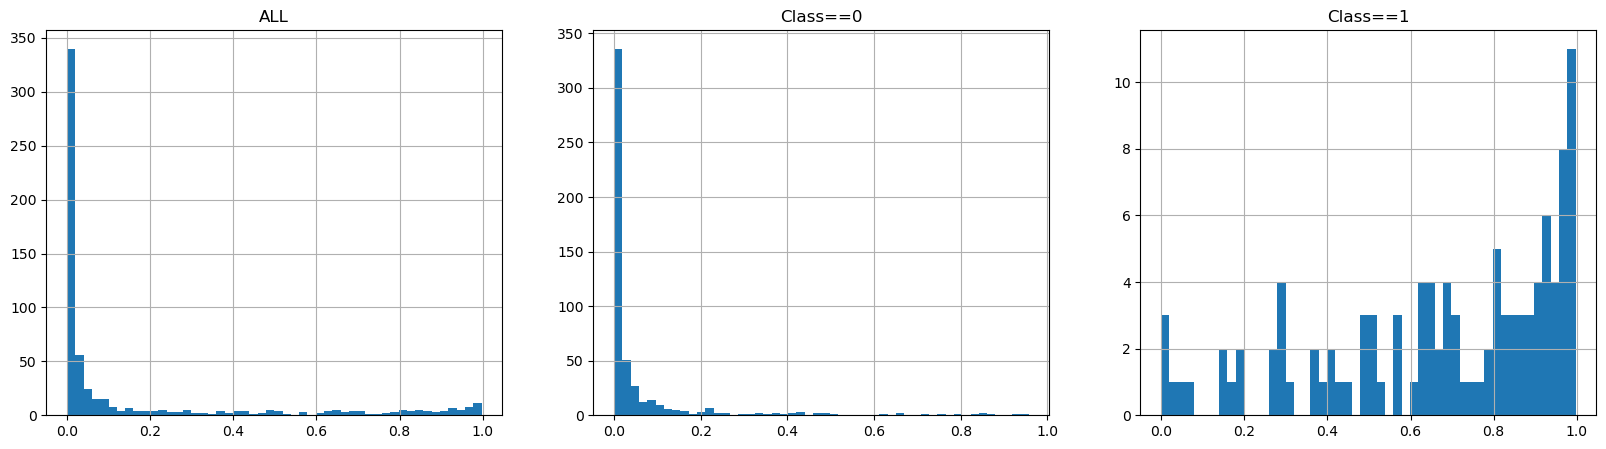

CV repeat nbr: 1 - metric: 0.2702


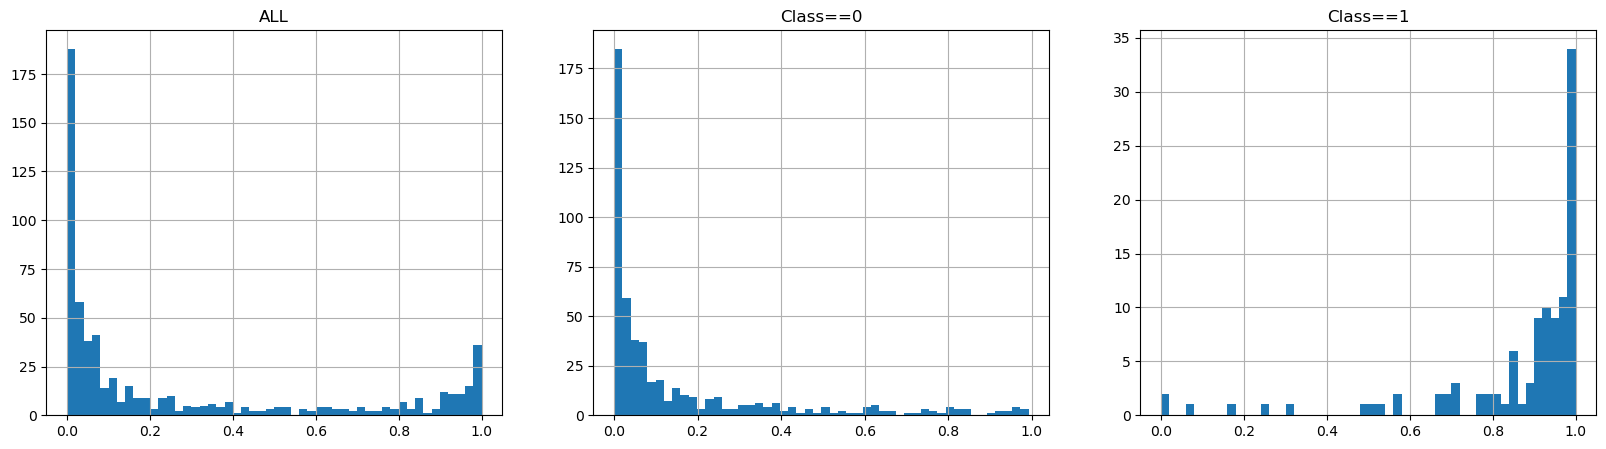

####################################################################################################
CV repeat nbr: 2 - metric: 0.4116


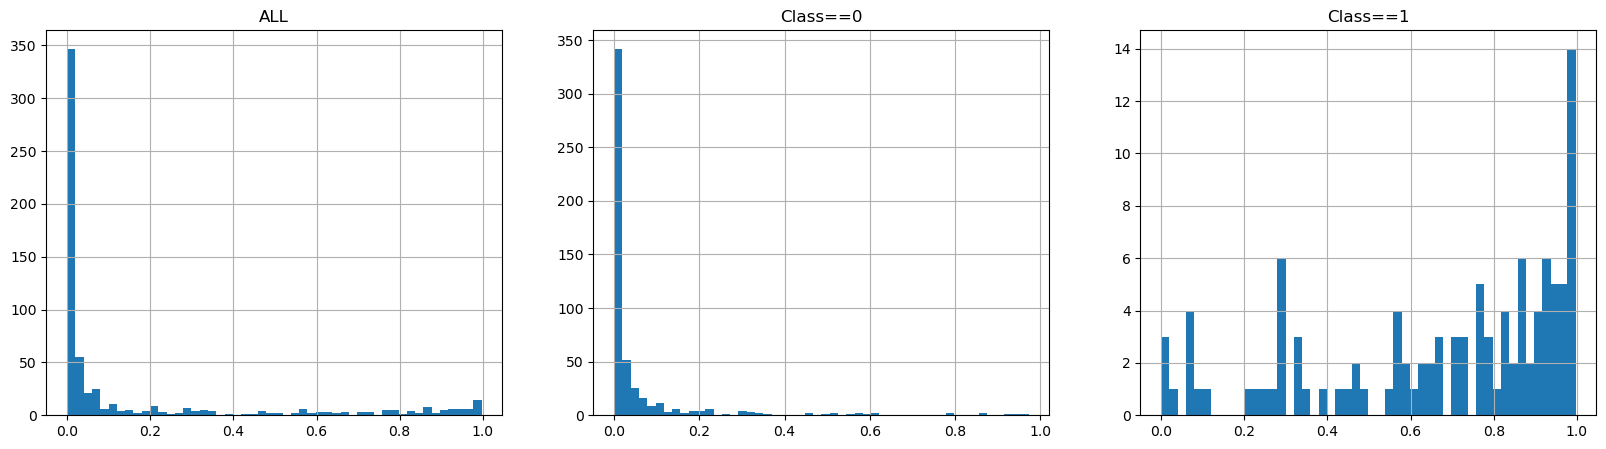

CV repeat nbr: 2 - metric: 0.2892


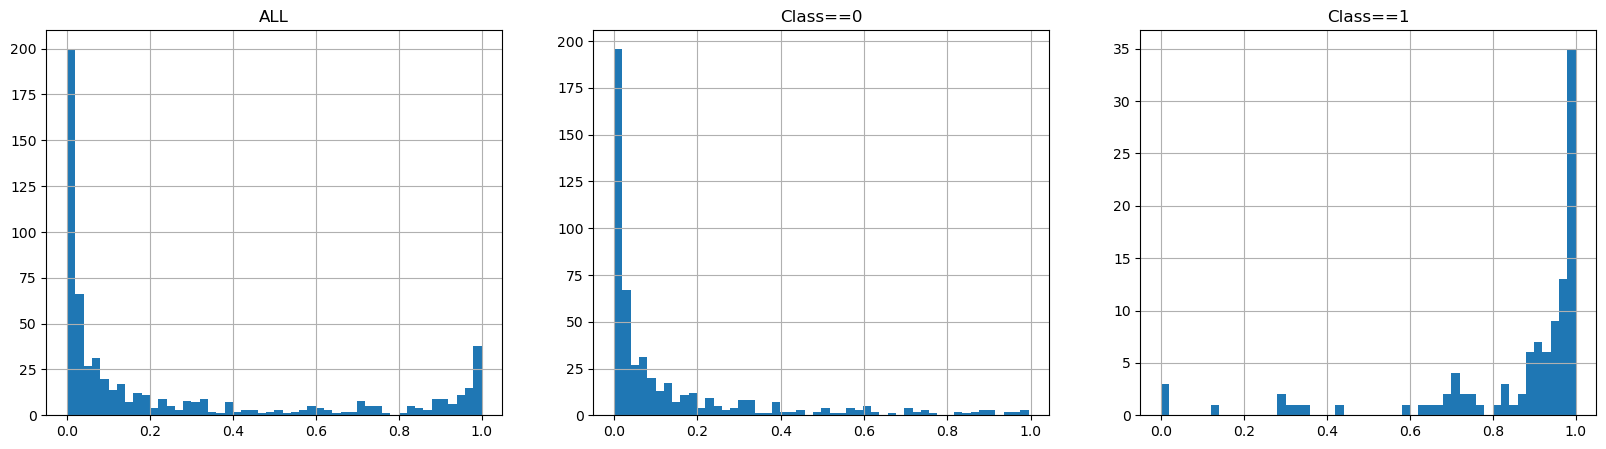

####################################################################################################
CV repeat nbr: 3 - metric: 0.3544


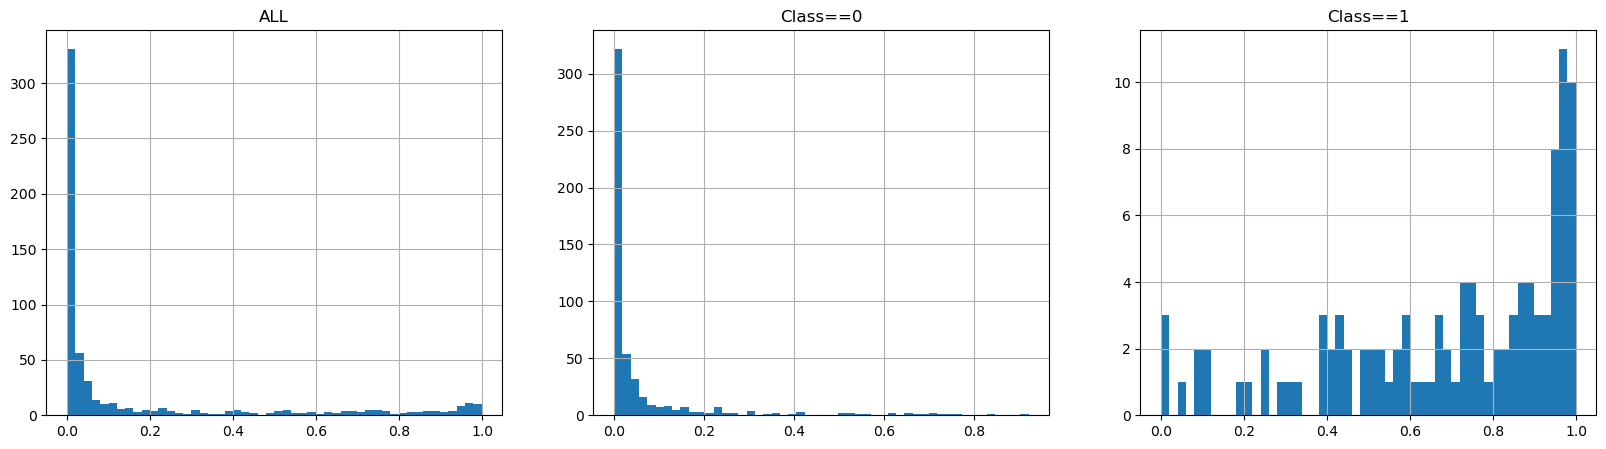

CV repeat nbr: 3 - metric: 0.2586


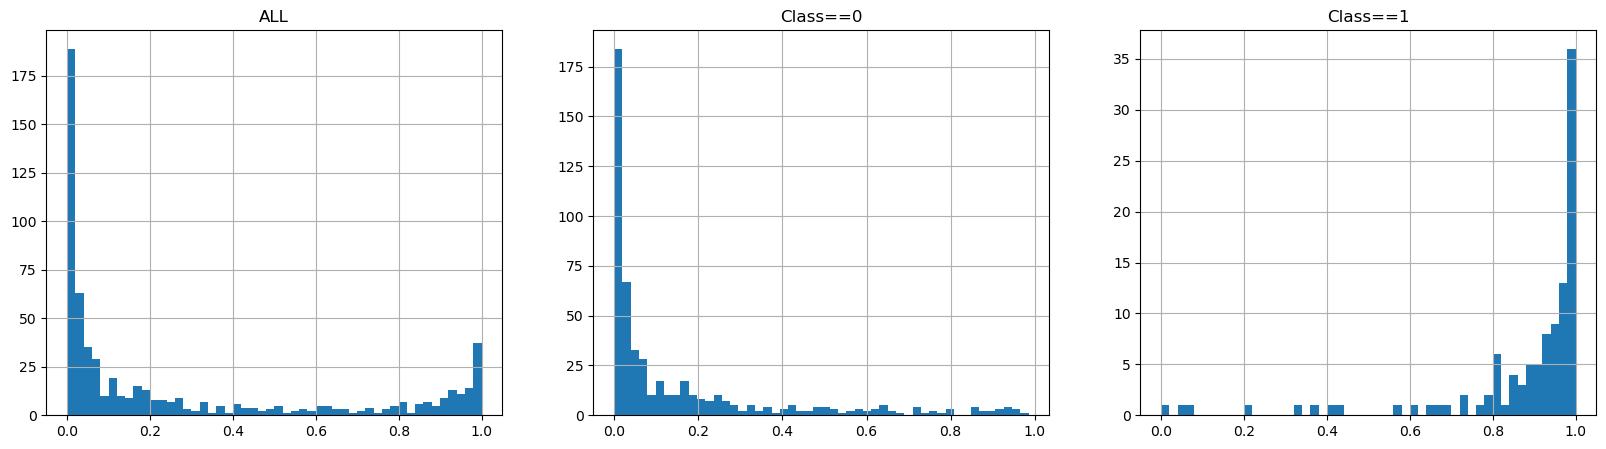

####################################################################################################
CV repeat nbr: 4 - metric: 0.3952


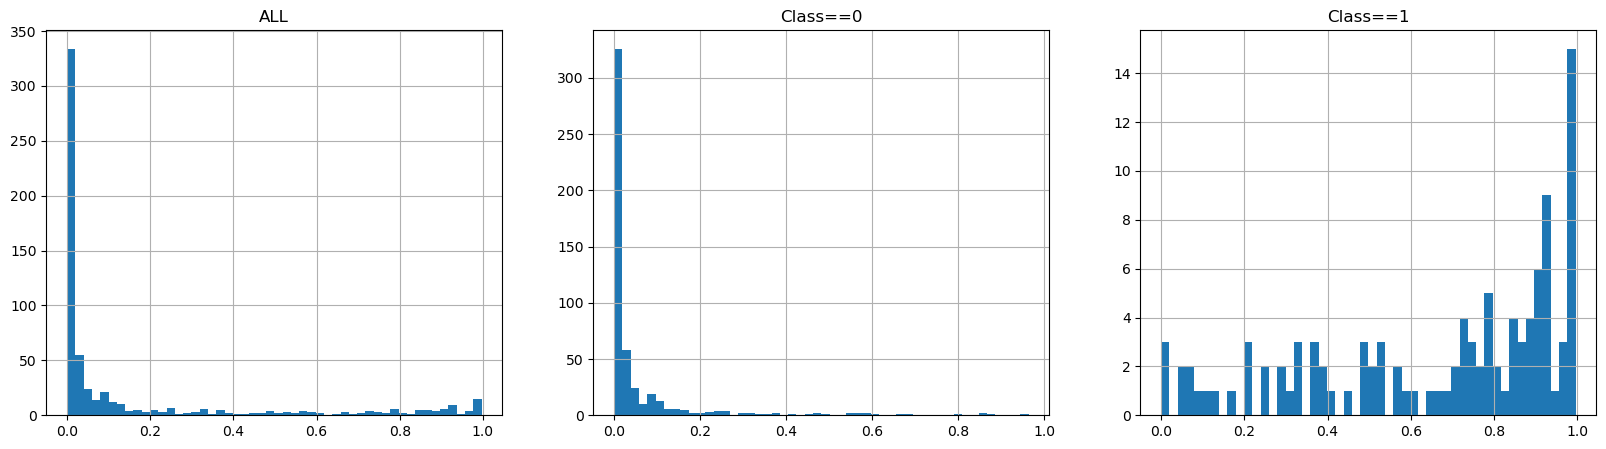

CV repeat nbr: 4 - metric: 0.2729


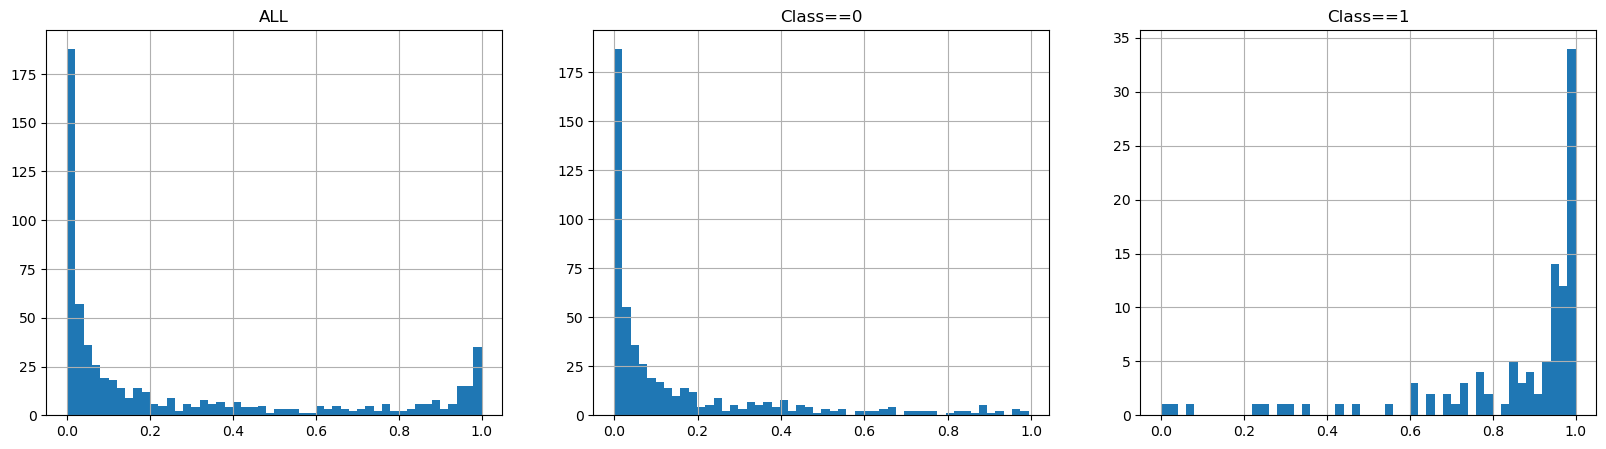

####################################################################################################
CV repeat nbr: 5 - metric: 0.4056


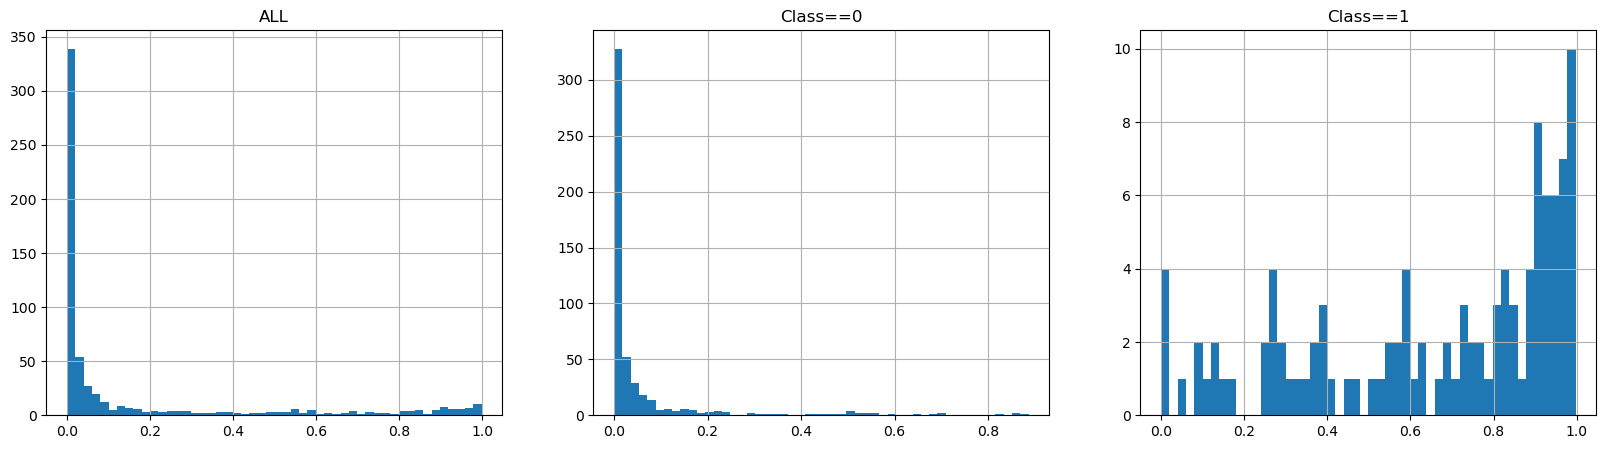

CV repeat nbr: 5 - metric: 0.2824


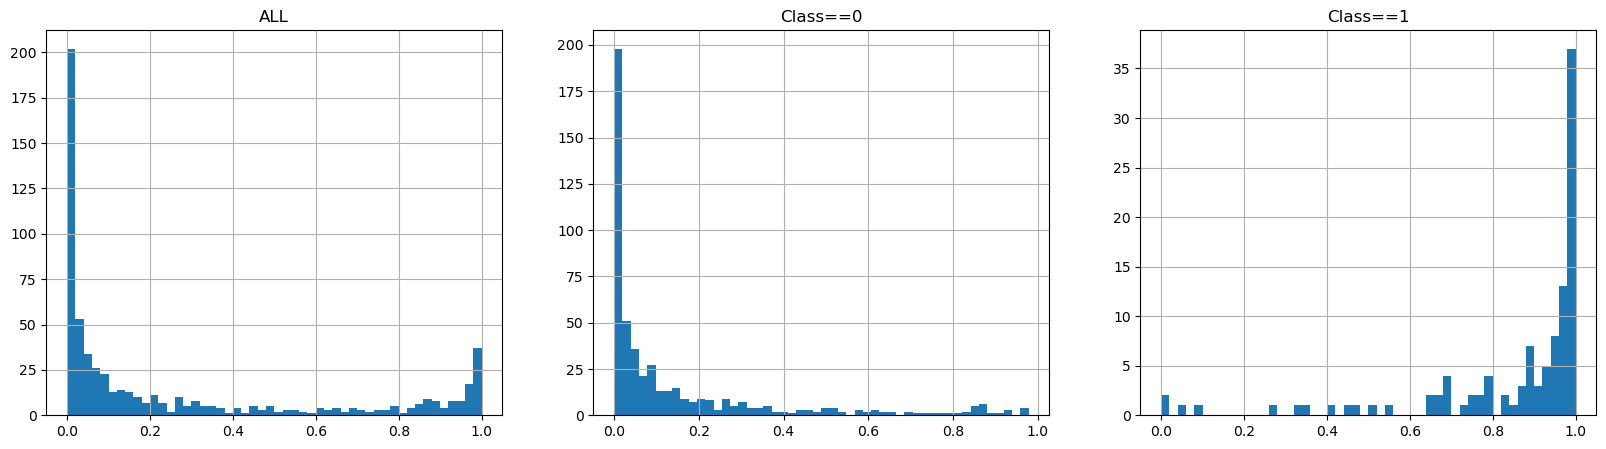

####################################################################################################
CV repeat nbr: 6 - metric: 0.3837


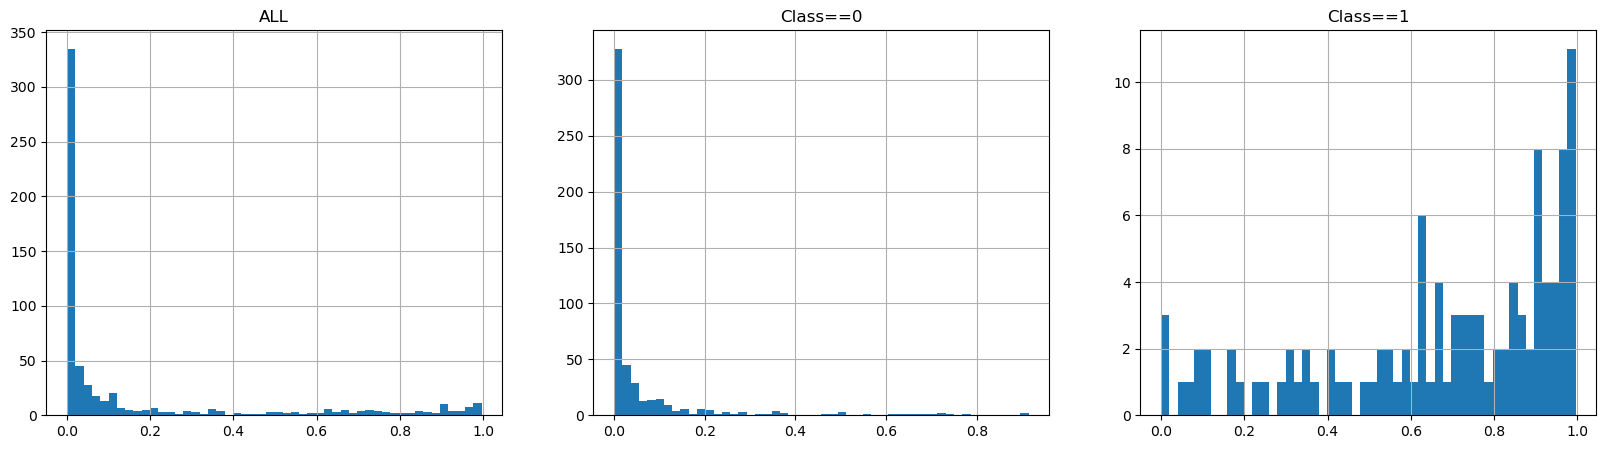

CV repeat nbr: 6 - metric: 0.2740


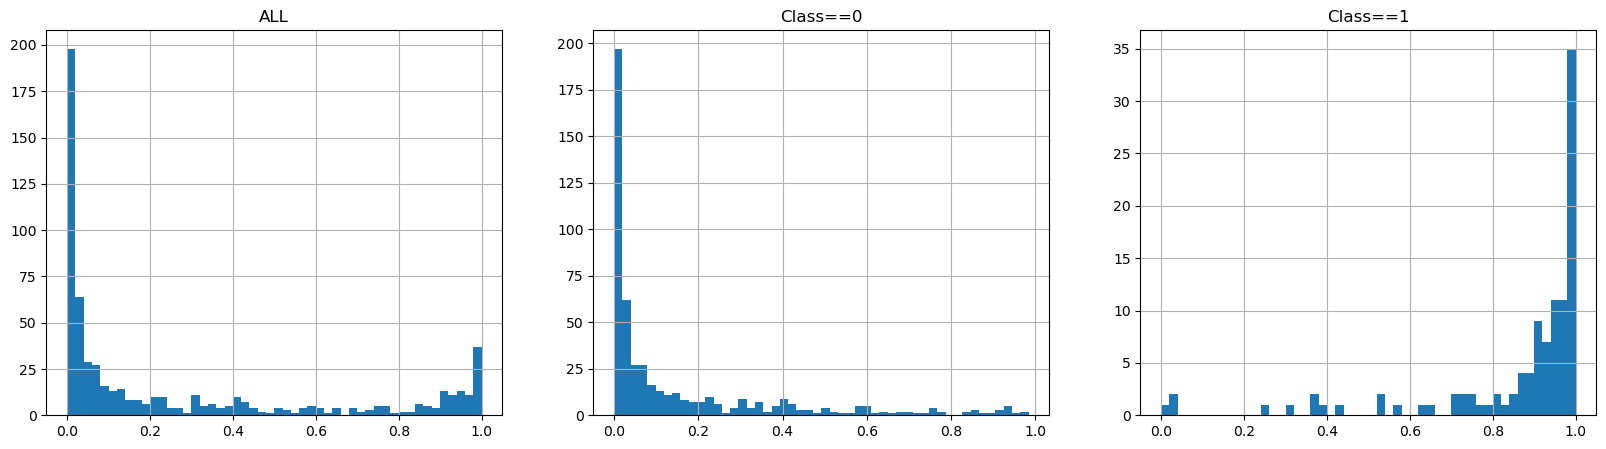

####################################################################################################
CV repeat nbr: 7 - metric: 0.4093


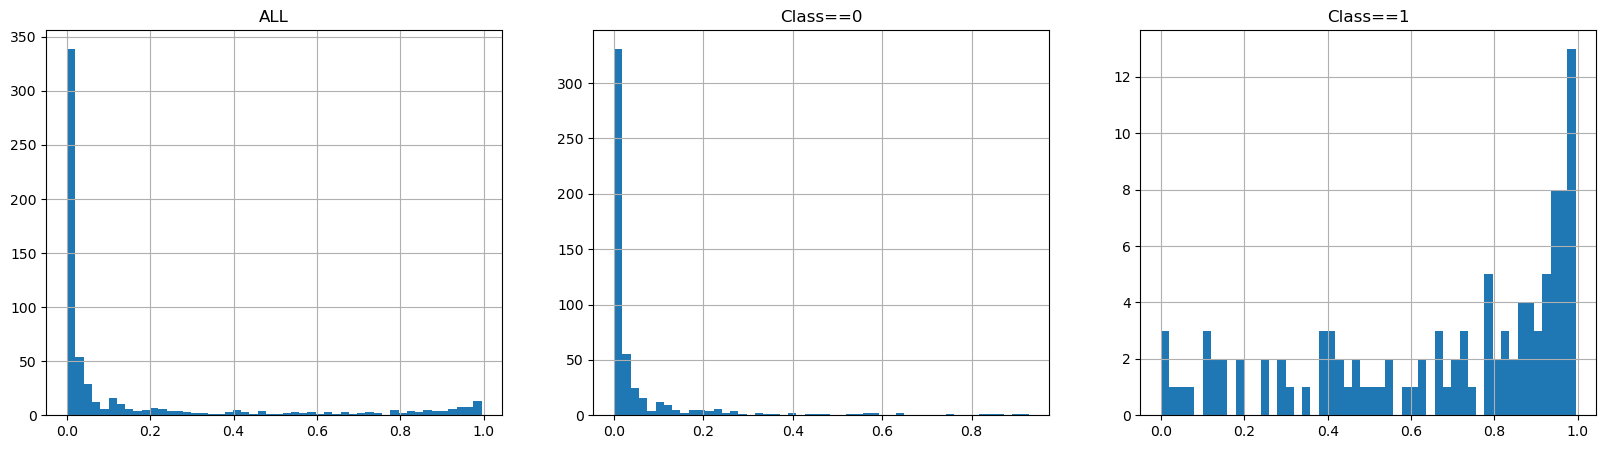

CV repeat nbr: 7 - metric: 0.2866


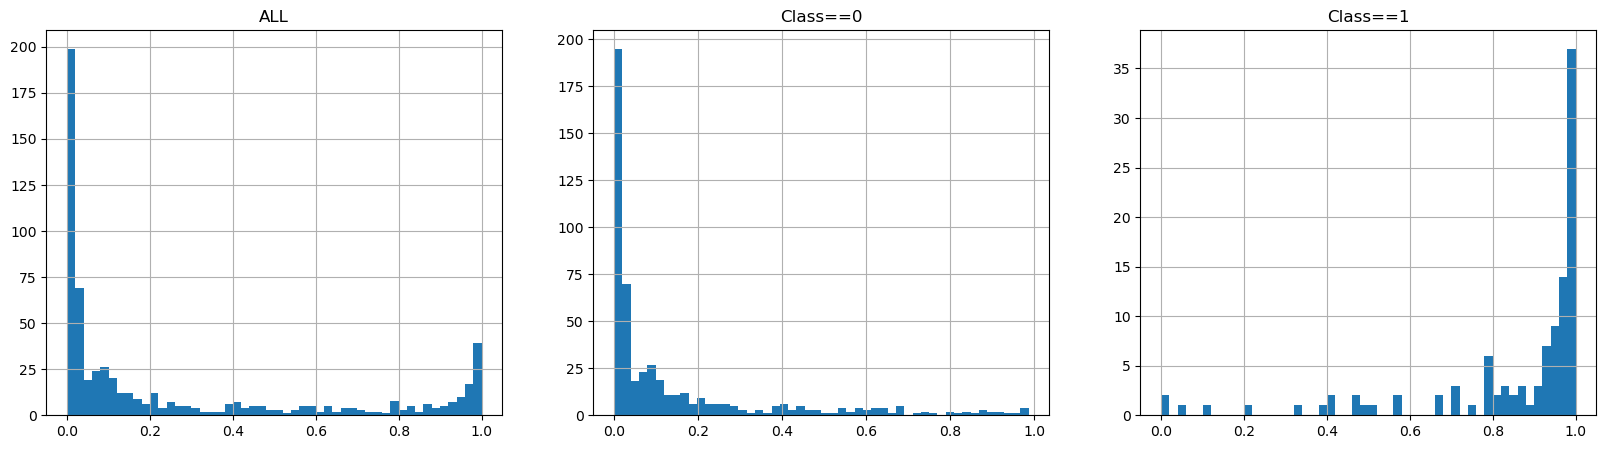

####################################################################################################
CV repeat nbr: 8 - metric: 0.4292


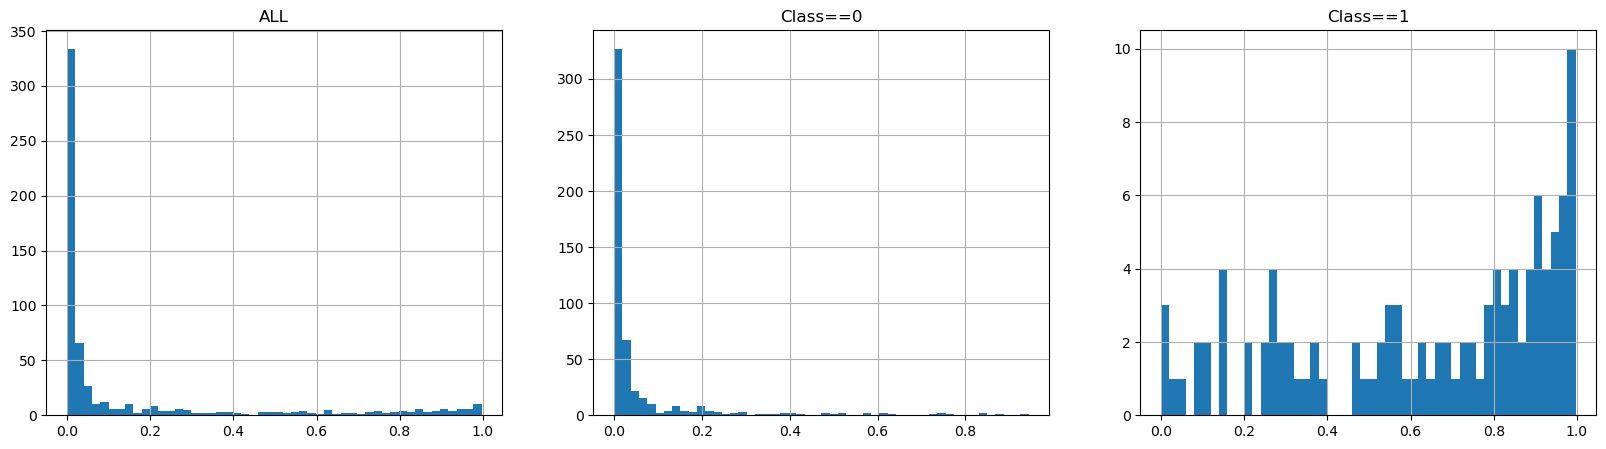

CV repeat nbr: 8 - metric: 0.2903


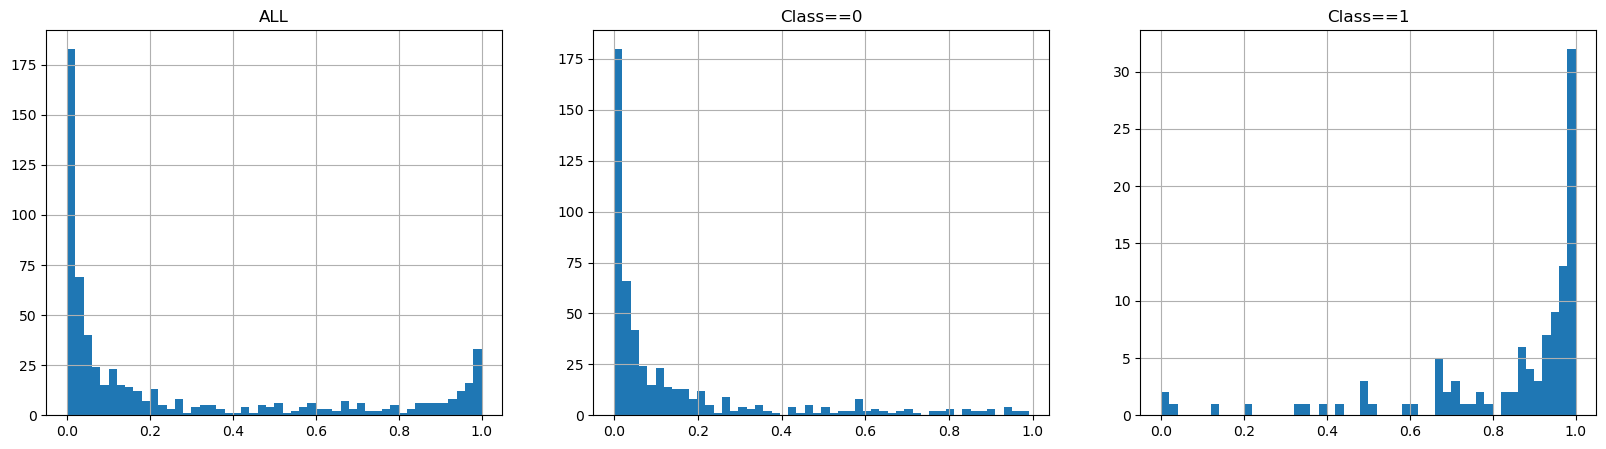

####################################################################################################
CV repeat nbr: 9 - metric: 0.3719


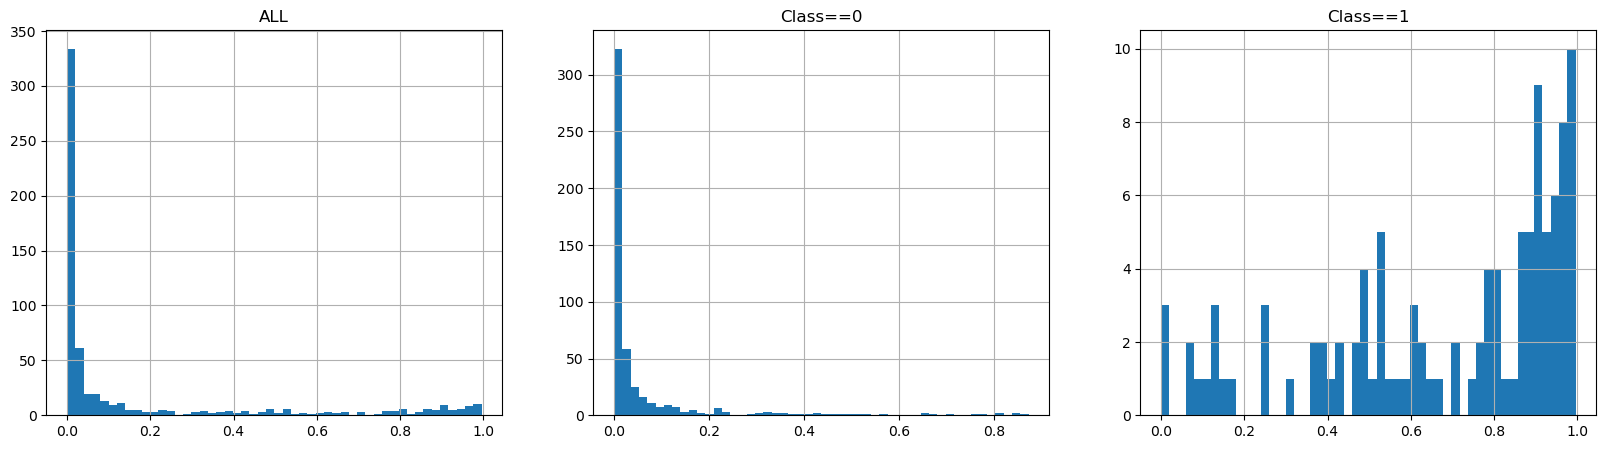

CV repeat nbr: 9 - metric: 0.2670


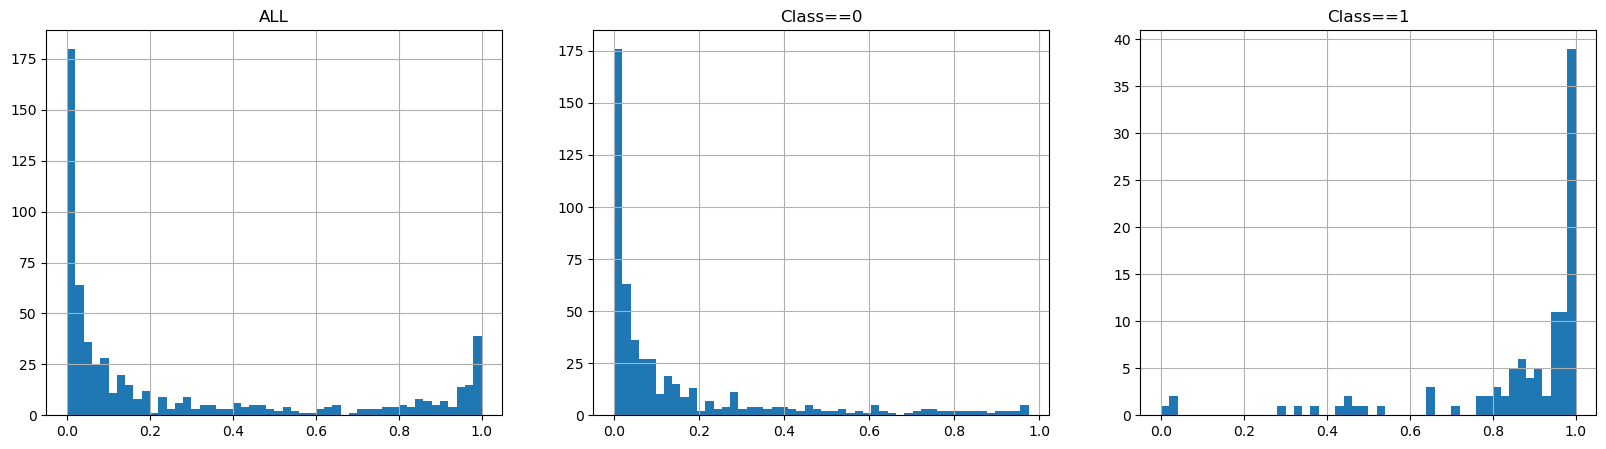

####################################################################################################
CV repeat nbr: 10 - metric: 0.4072


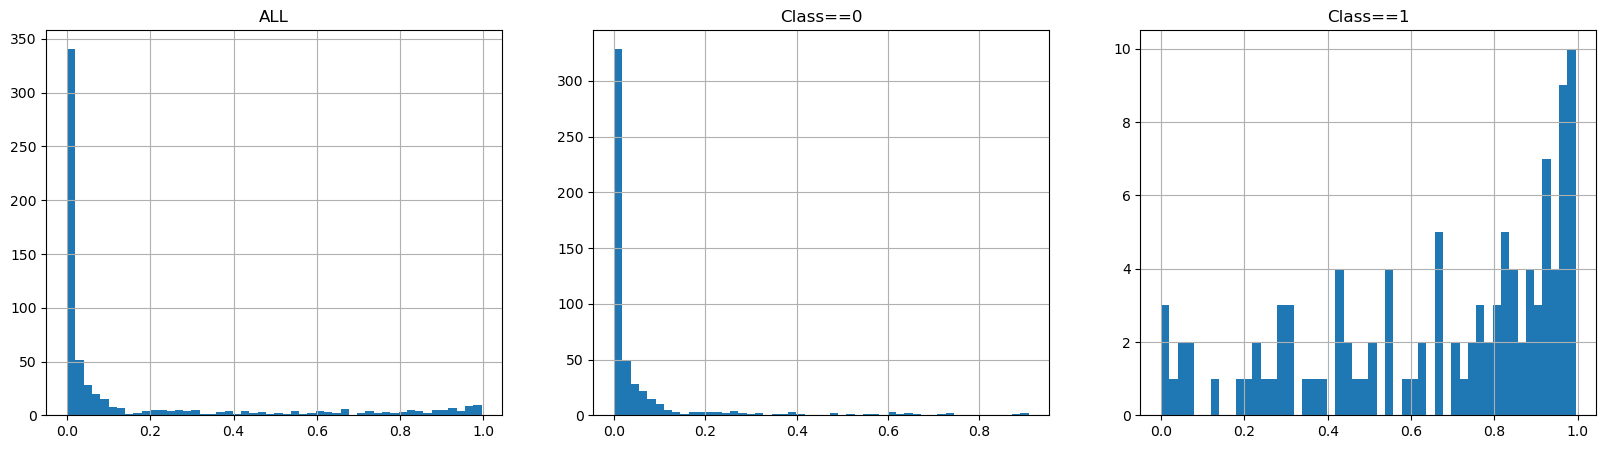

CV repeat nbr: 10 - metric: 0.2847


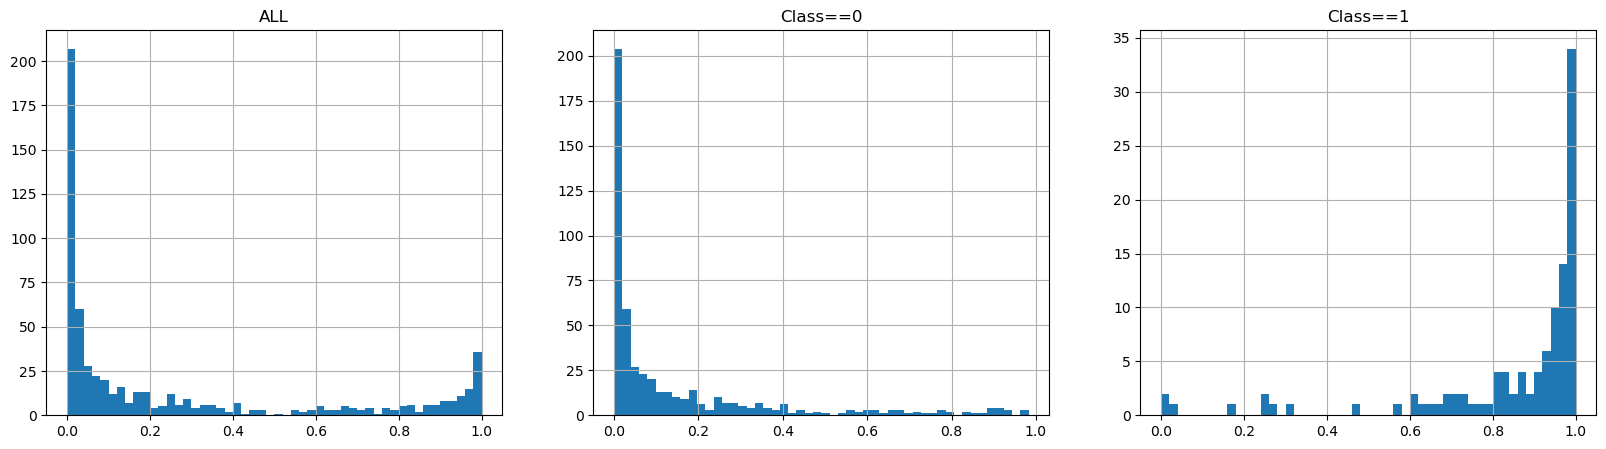

In [13]:
for i,oof in enumerate(oof_dfs):
    print("#"*100)
    oof = oof.copy()
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()
    
    p0 = 1 - oof.pred_proba.values.copy()
    p1 = oof.pred_proba.values.copy()
    p1 *= scale_factor
    scaled_p1 = p1 / (p0+p1)
    oof["pred_proba"] = scaled_p1
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()

***
# inference

In [14]:
predicted_probs = [
    model.predict_proba(test[input_cols])[:,1] 
    for model in models
]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.35655293, 0.35655293, 0.35655293, 0.35655293, 0.35655293],
      dtype=float32)

In [15]:
predicted_probs = calibrate_probs(predicted_probs, scale_factor)
predicted_probs

array([0.75915724, 0.75915724, 0.75915724, 0.75915724, 0.75915724],
      dtype=float32)

In [16]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.to_csv("submission.csv", index=False)
sub.describe()

,class_0,class_1
count,5.000000,5.000000
mean,0.240843,0.759157
std,0.000000,0.000000
min,0.240843,0.759157
25%,0.240843,0.759157
50%,0.240843,0.759157
75%,0.240843,0.759157
max,0.240843,0.759157


***
## save artifacts


In [17]:
joblib.dump(models, "models.pkl")
joblib.dump(oof_dfs, "oof_dataframes.pkl")
oof_scores.to_csv("oof_scores.csv", index=False)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

***